In [6]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(123456)

from scipy.io import wavfile

import os
# from audio_dataset import AudioDataset
torch.random.manual_seed(0)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [9]:
model = bundle.get_model()

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [17]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
# sliced_dataset = "shorter_audio_dataset"
# sliced_dataset_lenght = 4013
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, normalize=False):
        bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        model = bundle.get_model()

        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.wavs = []
        self.features = []
        self.labels = []
        self.min_val = 10e10
        self.max_val = 0
        print("Start reading files")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                _, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                features, _ = model.extract_features(wav)

                self.max_val = max(wav) if max(wav) > self.max_val else self.max_val
                self.min_val = min(wav) if min(wav) < self.min_val else self.min_val
                
                self.wavs.append(wav)
                self.features.append(features)
                self.labels.append(label)
        if normalize:
            for i in range(len(self.wavs)):
                self.wavs[i] = (self.wavs[i] - self.min_val) / (self.max_val - self.min_val)
                # self.wavs = (self.wavs - self.mu) / self.std  
                    
        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\nNormalization: {}".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std, normalize))
        print("="*40)
    
    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        wav = self.wavs[idx]
        features = self.features[idx]
        label = self.labels[idx]
        wav_tensor = torch.from_numpy(wav)
        features_tensor = torch.from_numpy(features)
        label_tensor = torch.tensor(label)
        return features_tensor, label_tensor


In [18]:
audio_dataset = AudioDataset(root_path="../data/", drop_both=True, use_short=True, normalize=True)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = int(dataset_len * 0.7), int(dataset_len * 0.2), int(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))

kwargs = {'batch_size': 1, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

Start reading files
Loaded DATABASE from ../data/short_audio_dataset
1000 total file
Longest file is 16050 long
Mean: 0.49696463346481323
Standard deviation: 0.03580576553940773
Normalization: True


In [23]:
for x,y in loader_train:
    with torch.inference_mode():
        features, _ = model.extract_features(x)
        print(len(features))
        break

12


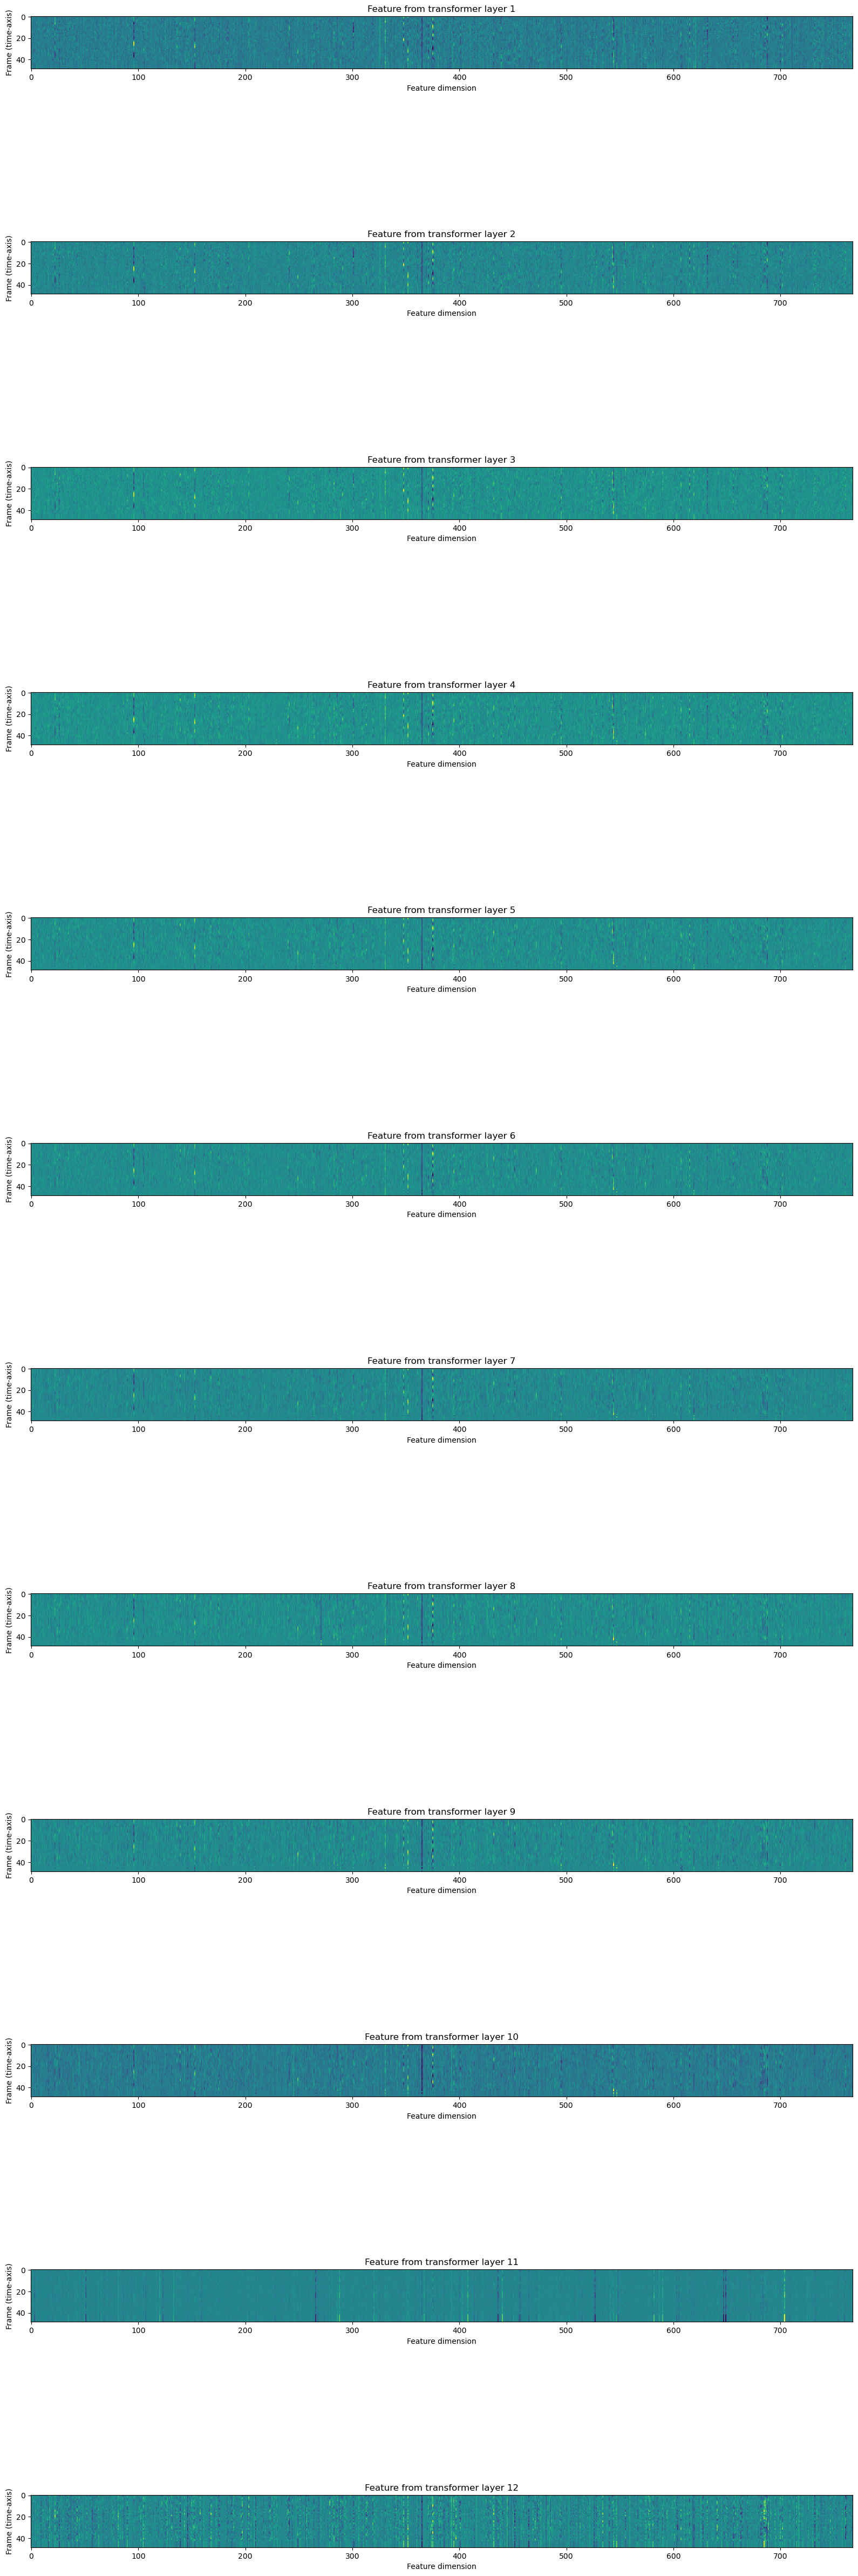

In [22]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()